In [1]:
from tensorflow import keras
from keras.layers import (Conv2D, SeparableConv2D, DepthwiseConv2D, BatchNormalization, MaxPooling2D, SpatialDropout2D,
                          Input, Embedding, LSTM, Bidirectional, Conv1D, SpatialDropout1D, GlobalMaxPooling1D,
                          MaxPooling1D, LocallyConnected2D, Dense, Flatten, Dropout, Add)
from keras import Model
from visualize import visualize
import visualize as vis

2023-02-04 13:08:04.268015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 13:08:04.412672: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-04 13:08:04.450091: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-04 13:08:04.991239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
count_map = {}


def generate_dense_blocks(features, num_blocks, input_layer, name_template="dense"):
    global count_map
    _l = input_layer
    for i in range(num_blocks):
        _l = BatchNormalization()(_l)
        count_to_use = count_map.get(name_template, 1)
        _l = Dense(features, activation='swish', name=f"{name_template}_{count_to_use}")(_l)
        count_map[name_template] = count_to_use + 1
        _l = Dropout(0.25)(_l)
    return _l

In [3]:
# Build the model
count_map = {}
activation = 'relu'
input_shape = 256
kernel = 3
pool = 2
padding = 'same'

dropout = 0.25

inputs = keras.Input(shape=input_shape)
features = 128
a = generate_dense_blocks(256, 1, inputs, name_template='a')
a1 = generate_dense_blocks(256, 1, a, name_template='a1')
a2 = generate_dense_blocks(256, 1, a, name_template='a2')
a = Add(name='sum_a')([a1, a2, a])
b = generate_dense_blocks(512, 1, inputs, name_template='b')
b1 = generate_dense_blocks(32, 2, b, name_template='b1')
b2 = generate_dense_blocks(32, 2, b, name_template='b2')
b = Add(name='sum_b')([b1, b2])
b = generate_dense_blocks(256, 2, b, name_template='b')
# c = generate_dense_blocks(features, 3, inputs, name_template='c')

a = Add(name='sum_ab')([a, b])

d = generate_dense_blocks(1024, 2, a, name_template='d')
e = generate_dense_blocks(32, 3, a, name_template='e')
# e1 = generate_dense_blocks(features, 2, e, name_template='e1')
e1 = generate_dense_blocks(1024, 2, e, name_template='e1')
e2 = Add(name="sum_b2_e")([e, b2])
e2 = generate_dense_blocks(1024, 2, e2, name_template='e2')
# f = generate_dense_blocks(features,4, a, name_template='f')
# e = Add(name='sum_e')([e1,e2])
g = Add(name='sum_d_e')([d, e1, e2])

y = Dropout(dropout, name='dropout_out')(g)
outputs = Dense(10, name='output', activation='softmax')(y)

model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()
# visualize(model)

2023-02-04 13:08:11.990280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 13:08:12.029556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 13:08:12.031147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 13:08:12.032993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 256)         1024        ['input_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 b_1 (Dense)                    (None, 512)          131584      ['batch_normalization_3[0][0]']  
                                                                                                  
 dropout_3 (Dropout)            (None, 512)          0           ['b_1[0][0]']                

"input_1_group":
	LayerGroup(input_1_group) primary layer input_1 with before: None, with after: None)
"batch_normalization_group":
	LayerGroup(batch_normalization_group) primary layer batch_normalization with before: None, with after: None)
"batch_normalization_3_group":
	LayerGroup(batch_normalization_3_group) primary layer batch_normalization_3 with before: None, with after: None)
"a_1_group":
	LayerGroup(a_1_group) primary layer a_1 with before: None, with after: dropout)
"b_1_group":
	LayerGroup(b_1_group) primary layer b_1 with before: None, with after: dropout_3)
"batch_normalization_1_group":
	LayerGroup(batch_normalization_1_group) primary layer batch_normalization_1 with before: None, with after: None)
"batch_normalization_2_group":
	LayerGroup(batch_normalization_2_group) primary layer batch_normalization_2 with before: None, with after: None)
"sum_a_group":
	LayerGroup(sum_a_group) primary layer sum_a with before: None, with after: None)
"batch_normalization_4_group":
	Laye

/opt/conda/envs/pytorch/lib/python3.9/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: Warning: node 'batch_normalization_group', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


generated pdf file
Errors: 0, Warnings: 0, Badboxes: 0


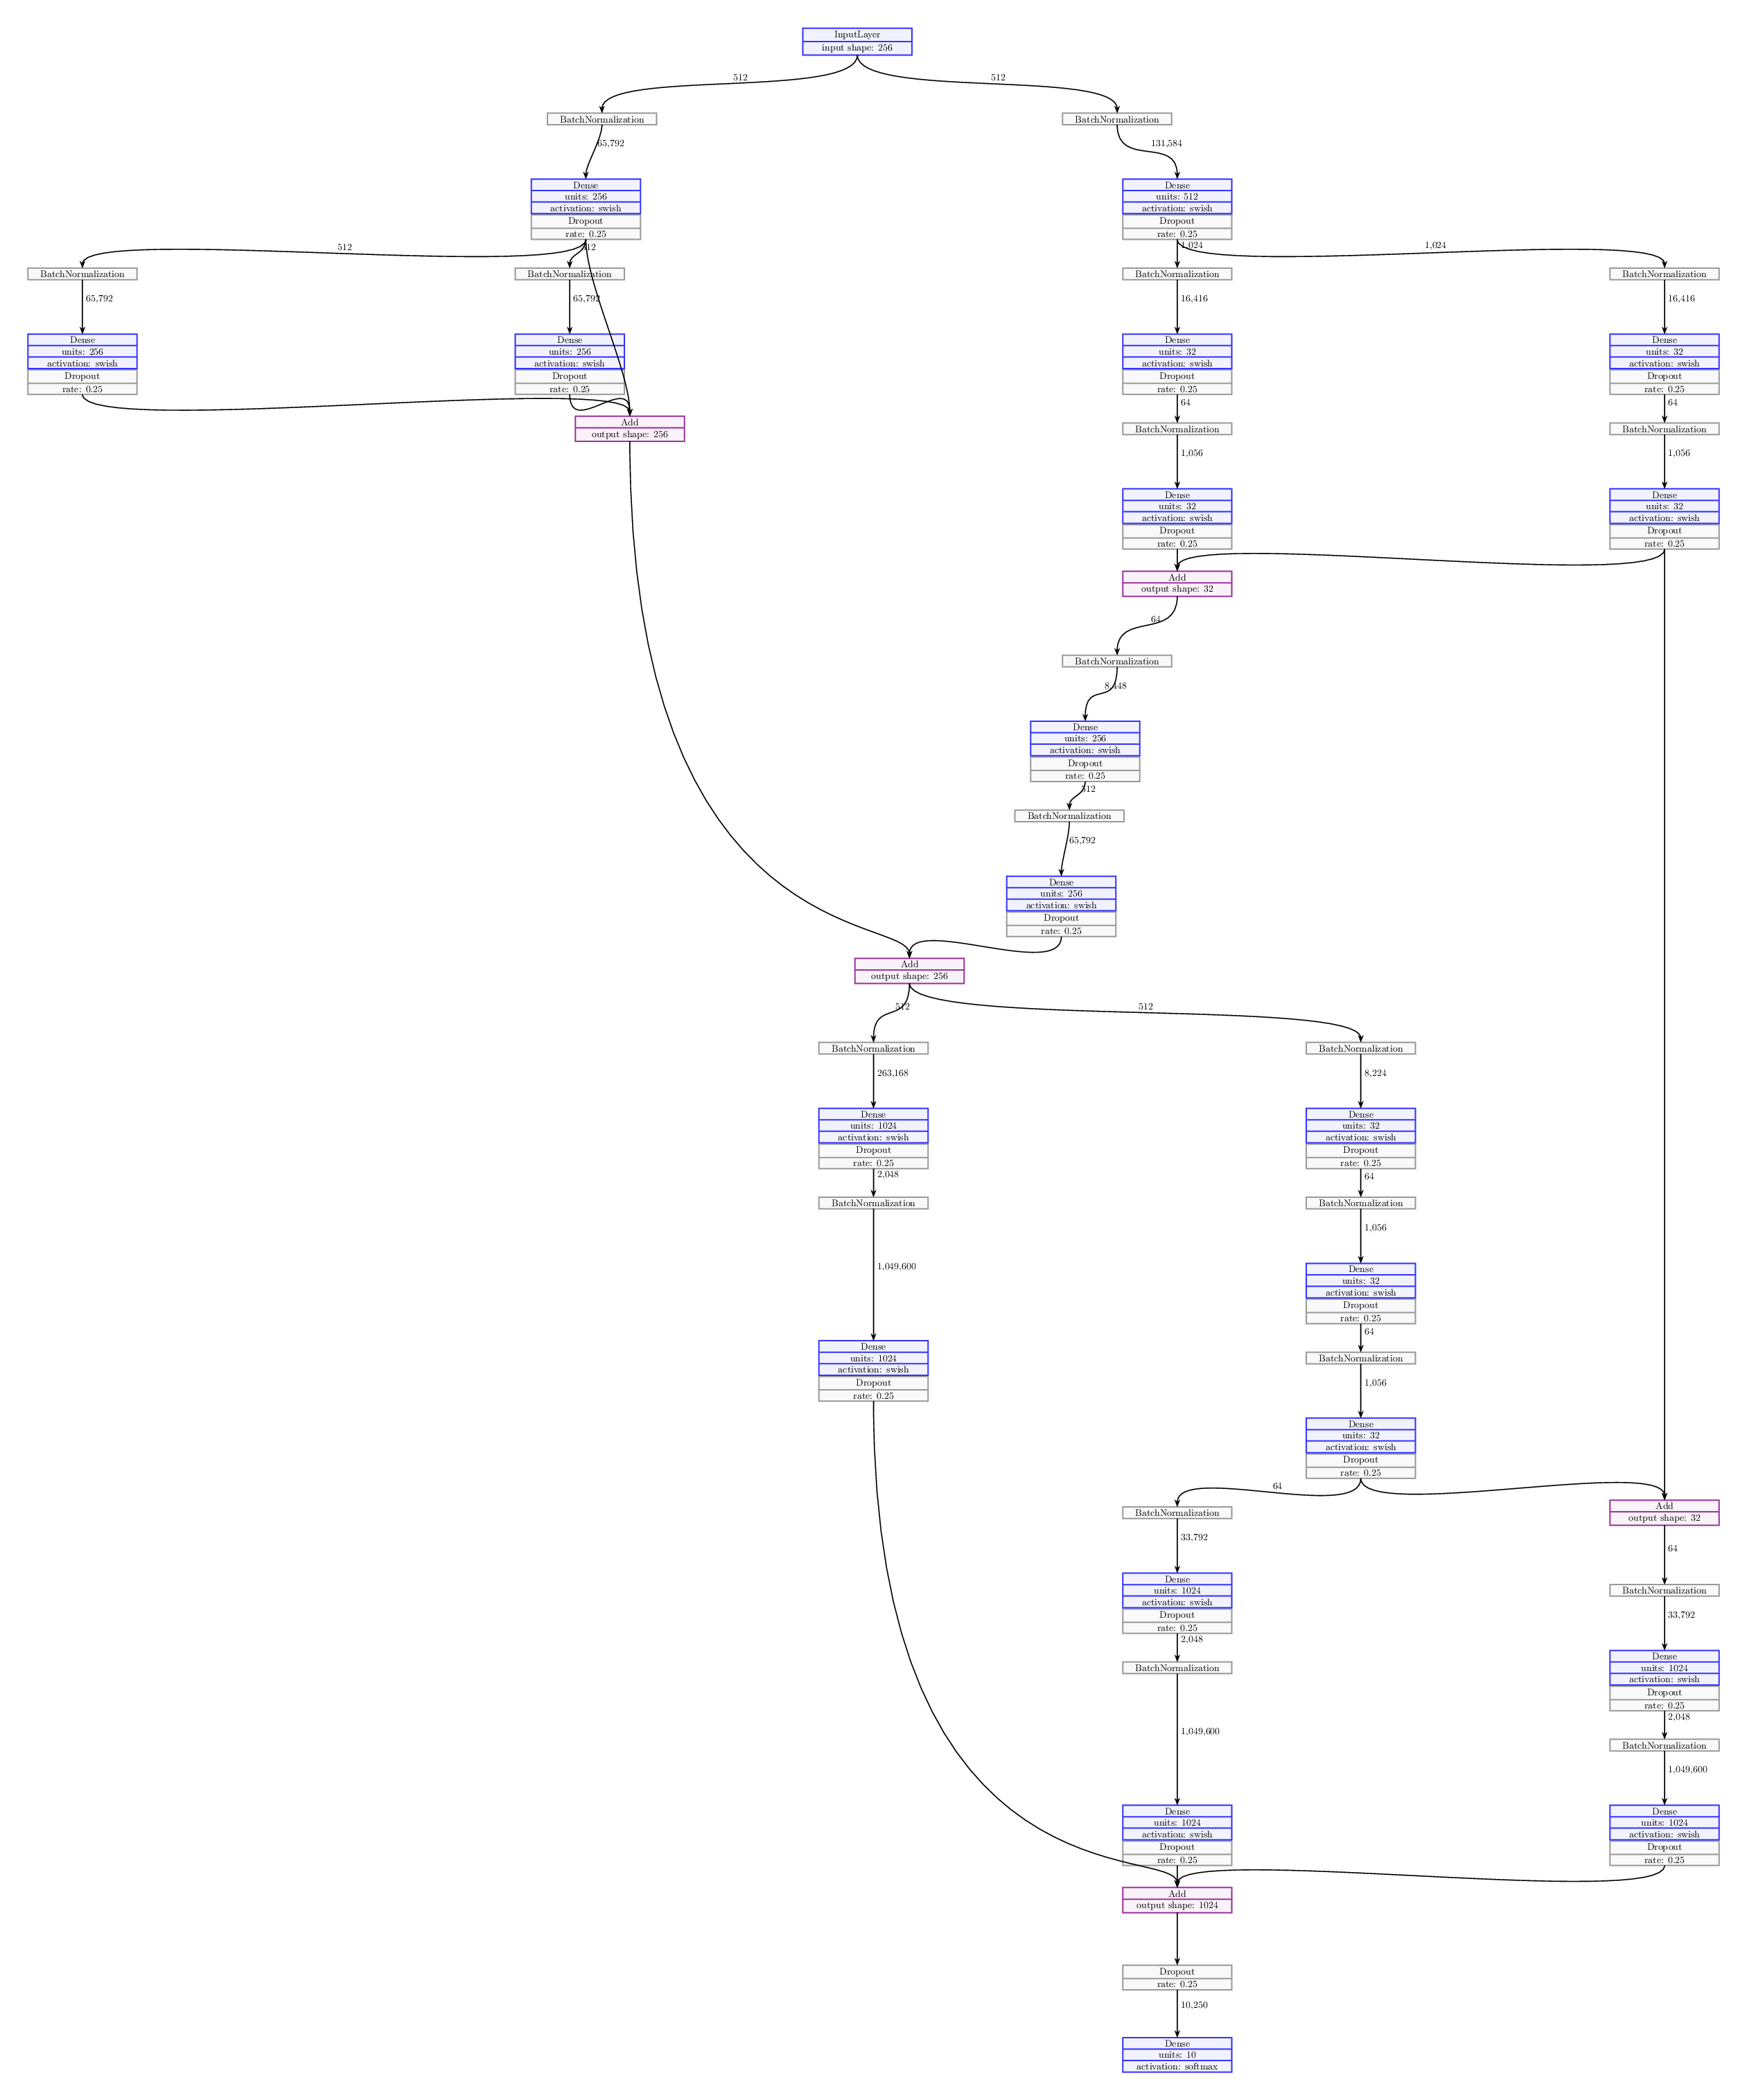

In [4]:
visualize(model, resolution=100, canvas_width=55, canvas_height=70)

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from tensorflow import keras
from keras.layers import (Conv2D, SeparableConv2D, DepthwiseConv2D, BatchNormalization, MaxPooling2D, SpatialDropout2D,
                          Input, Embedding, LSTM, Bidirectional, Conv1D, SpatialDropout1D, GlobalMaxPooling1D,
                          MaxPooling1D, LocallyConnected2D, Dense, Flatten, Dropout, Add)
from keras import Model
from visualize import visualize

In [17]:
pretrained_model = keras.applications.EfficientNetB0(include_top=False, weights=None, input_shape=(256, 256, 3))

In [18]:
# try different pretrained models, dont include weights because we are only interested in the architecture


# pretrained_model.summary()

visualize(pretrained_model, resolution=120, canvas_width=15, canvas_height=400)

"input_2_group":
	LayerGroup(input_2_group) primary layer input_2 with before: None, with after: None)
"rescaling_1_group":
	LayerGroup(rescaling_1_group) primary layer rescaling_1 with before: None, with after: None)
"normalization_1_group":
	LayerGroup(normalization_1_group) primary layer normalization_1 with before: None, with after: None)
"stem_conv_pad_group":
	LayerGroup(stem_conv_pad_group) primary layer stem_conv_pad with before: None, with after: None)
"stem_conv_group":
	LayerGroup(stem_conv_group) primary layer stem_conv with before: None, with after: stem_bn)
"stem_activation_group":
	LayerGroup(stem_activation_group) primary layer stem_activation with before: None, with after: None)
"block1a_dwconv_group":
	LayerGroup(block1a_dwconv_group) primary layer block1a_dwconv with before: None, with after: block1a_bn)
"block1a_activation_group":
	LayerGroup(block1a_activation_group) primary layer block1a_activation with before: None, with after: None)
"block1a_se_squeeze_group":
	

ValueError: Layer block2b_drop not found